In [1]:
from scope_utils import set_scope, get_waveform, get_trace_data, TraceData
from Peak_Search import ini_peak_search, reso_det, mod_peak_search,zero_measure,fir_measure
import pyvisa
from windfreak import SynthHD
import numpy as np
import numpy.typing as npt
import matplotlib.pyplot as plt
import h5py
import time
import tqdm
from typing import List, Tuple, Sequence
from utils_dBm import dBm_to_Vpp, Vpp_to_dBm, Vpp_to_Vrms, Vrms_to_watt
import csv

In [2]:
resource_name_windfreak = "COM7"
resource_name_oscilloscope = "USB0::0x1AB1::0x04CE::DS1ZA203916635::INSTR"

rm = pyvisa.ResourceManager()

scope: pyvisa.resources.USBInstrument = rm.open_resource("USB0::0x1AB1::0x04CE::DS1ZA203916635::INSTR", read_termination = "\n")
synthd = SynthHD(resource_name_windfreak)
synthd.init()
rf_out = 0

## Initialize scope settings

In [3]:
def select_scale(scale: float) -> float:
    scale_steps = np.ravel([np.array([5,2,1]) * 10**x for x in np.linspace(1,-3,5)])[2:]
    if scale < 1e-3:
        scale_select = 1e-3
    else:
        for ids,s in enumerate(scale_steps):
            if scale >= s:
                scale_select = scale_steps[ids-1]
                break
    return scale_select

In [4]:
def get_rev_trace(
    scope: pyvisa.resources.USBInstrument, channels: Sequence[int]
)-> TraceData:
    scope.write(":SINGLE")
    while True:
        if scope.query(":TRIG:STAT?") == "STOP":
            break
        time.sleep(0.05)
    trace = get_trace_data(scope, channels)
    scope.write(":CLEAR")
    ref = trace.transmission
    rev= -1.*ref+np.mean(ref) 
    return rev

In [5]:
time_div = 1e-3
t_offset = 2e-3
offset = -0.3

channel = 2
scope.write(f":CHAN{channel}:DISP 1")
scale_ch2 = 0.05

# scale_ch1 = dBm_to_Vpp(amplitude_int)/ndiv*2
# scale_ch1 = select_scale(scale_ch1)

set_scope(scope, channel, scale_ch2, offset, time_div, t_offset)

scope.write(":RUN")
scope.write(":ACQuire:MDEPth 30000")
#scope.write(":CLEAR")

23

In [6]:
ini_rev_data = get_rev_trace(scope, [channel])

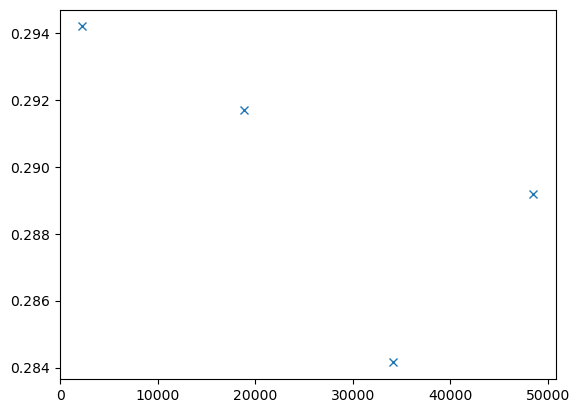

In [7]:
ini_peak = ini_peak_search(ini_rev_data)
ini_reso = reso_det(ini_peak)
plt.plot(ini_peak,ini_rev_data[ini_peak],"x")

Signal generator input  is 0 dB

In [8]:
synthd[rf_out].enable = False
zero_amp_all = []
fir_amp_all = []
pow_max_all = []
scan_data = []
power_scan = np.linspace(-15, 8, 101)
fre_scan = np.linspace(625e6,1625e6,41)

for rf_fre in tqdm.tqdm(fre_scan):
    synthd[rf_out].enable = False
    ini_rev_data = get_rev_trace(scope, [channel])
    ini_peak = ini_peak_search(ini_rev_data)
    ini_reso = reso_det(ini_peak)
    zero_amp = []
    fir_amp = []
    synthd[rf_out].enable = True
    for shdpower in tqdm.tqdm(power_scan):
        synthd[rf_out].frequency = rf_fre
        synthd[rf_out].power = shdpower
        mod_rev_data  = get_rev_trace(scope, [channel])
        #time.sleep(1)
        mod_peak = mod_peak_search(mod_rev_data)
        mod_zero_peak1,mod_zero_peak2, mod_zero_amp = zero_measure(mod_rev_data, ini_peak, mod_peak, ini_reso)
        mod_fir_peak, mod_fir_amp = fir_measure(mod_rev_data, ini_peak, mod_peak, rf_fre,ini_reso)
        if mod_fir_peak == mod_zero_peak2:
            mode_fir_amp = 0.05
        zero_amp.append(mod_zero_amp)
        fir_amp.append(mod_fir_amp)
        #time.sleep(1)
    pow_max = power_scan[fir_amp.index(max(fir_amp))]
    scan_data.append([rf_fre,pow_max])
    pow_max_all.append(pow_max)
    zero_amp_all.append(zero_amp)
    fir_amp_all.append(fir_amp)


100%|██████████| 41/41 [31:57<00:00, 46.78s/it]


In [9]:
synthd[rf_out].enable = False
scope.write(":RUN")

6

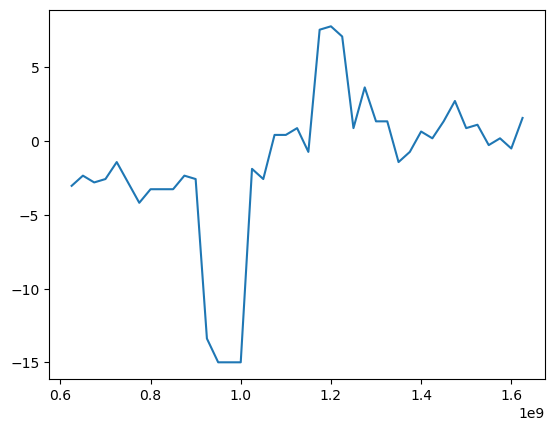

In [10]:
plt.plot(fre_scan,pow_max_all)

In [11]:
np.asarray(fir_amp_all).shape

(41, 101)

In [12]:
with open("2023_4_9_NLTL_powerscan_25MHzstep4.csv", "w", newline="") as csvfile:
    writer = csv.writer(csvfile, delimiter=',')
    writer.writerow([ "frequency [Hz]", "input_power [dBm]"])
    for row in scan_data:
        writer.writerow(row)

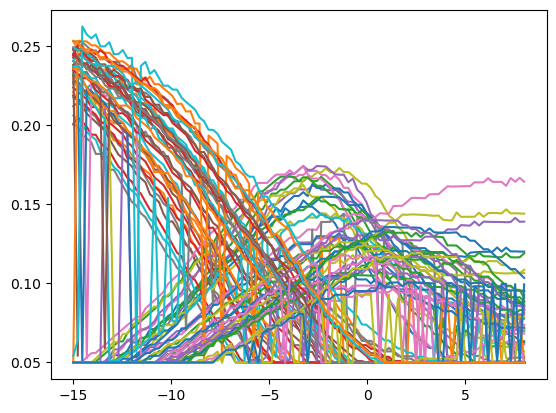

In [13]:
for i in range(41):
    plt.plot(power_scan,fir_amp_all[i])
    plt.plot(power_scan,zero_amp_all[i])

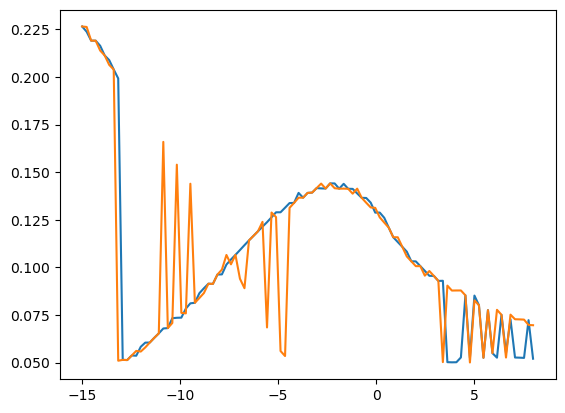

In [14]:
plt.plot(power_scan,fir_amp_all[14])
plt.plot(power_scan,zero_amp_all[14])